This notebook is for unsderstanding Robust Linear Regression of statsmodels

Reference : https://www.statsmodels.org/stable/generated/statsmodels.robust.robust_linear_model.RLM.html

versions :

    python 3.6.2
    statsmodels 0.8.0
    scikit-learn 0.19.1

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tools as st

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Prepare Data

In [2]:
# load data to use
data = sm.datasets.stackloss.load()

In [3]:
X = pd.DataFrame(data.exog, columns=data.exog_name)
Y = pd.DataFrame(data.endog, columns=[data.endog_name])

In [4]:
# view the content of data as DataFrame
X

,AIRFLOW,WATERTEMP,ACIDCONC
0,80.0,27.0,89.0
1,80.0,27.0,88.0
2,75.0,25.0,90.0
3,62.0,24.0,87.0
4,62.0,22.0,87.0
5,62.0,23.0,87.0
6,62.0,24.0,93.0
7,62.0,24.0,93.0
8,58.0,23.0,87.0
9,58.0,18.0,80.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b294710>]],
      dtype=object)

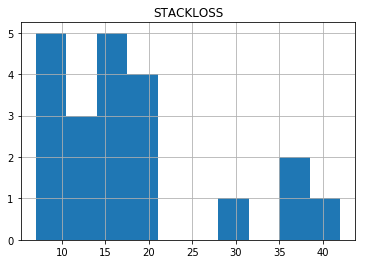

In [5]:
# check histgram of STACKLOSS. There seems to be some possible outliers away from the main cluter. 
Y.hist()

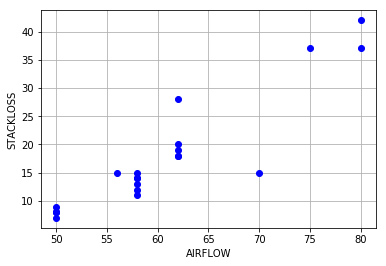

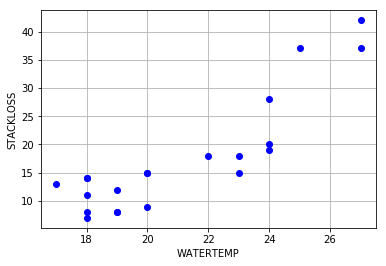

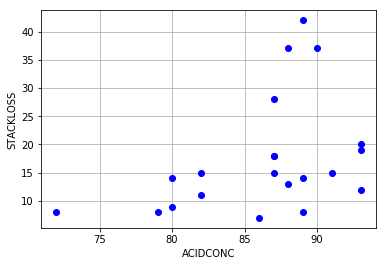

In [6]:
# distribution of STACKLOSS vs other variables

plt.figure(1)
plt.xlabel('AIRFLOW')
plt.ylabel('STACKLOSS')
plt.grid(True)
plt.plot(X['AIRFLOW'], Y, 'o', color='blue')

plt.figure(2)
plt.xlabel('WATERTEMP')
plt.ylabel('STACKLOSS')
plt.grid(True)
plt.plot(X['WATERTEMP'], Y, 'o', color='blue')

plt.figure(3)
plt.xlabel('ACIDCONC')
plt.ylabel('STACKLOSS')
plt.grid(True)
plt.plot(X['ACIDCONC'], Y, 'o', color='blue')

In [7]:
# Correlation coefficient
Z = pd.concat([Y, X], axis=1)
Z.corr()

,STACKLOSS,AIRFLOW,WATERTEMP,ACIDCONC
STACKLOSS,1.000000,0.919663,0.875504,0.399830
AIRFLOW,0.919663,1.000000,0.781852,0.500143
WATERTEMP,0.875504,0.781852,1.000000,0.390940
ACIDCONC,0.399830,0.500143,0.390940,1.000000


# Modeling

In [8]:
# add constant term to exogenous variable as well as the case of OLS 
data.exog = sm.add_constant(data.exog)

# M : robust criterion function for downweighting outliers. 
# There are other options : LeastSquares, HuberT, RamsayE, AndrewWave, TrimmedMean, Hampel, and TukeyBiweight 
# See the shapes of these weight fucntions : https://www.statsmodels.org/stable/rlm_techn1.html

huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT()) # use Huber weight function
hub_results = huber_t.fit()

print('--- Estimated Parameters ---')
print(hub_results.params)

print('--- Standard Error of Estimated Parameters ---')
print(hub_results.bse)

print('--- Result ---')
print(hub_results.summary(yname='y', xname=['var_%d' % i for i in range(len(hub_results.params))]))

--- Estimated Parameters ---
[-41.02649835   0.82938433   0.92606597  -0.12784672]
--- Standard Error of Estimated Parameters ---
[9.79189854 0.11100521 0.30293016 0.12864961]
--- Result ---
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 02 May 2019                                         
Time:                        01:46:19                                         
No. Iterations:                    19                                         
                 co

# Prediction

In [9]:
# prediction of training data(not test data)
huber_predicted = hub_results.predict(data.exog)

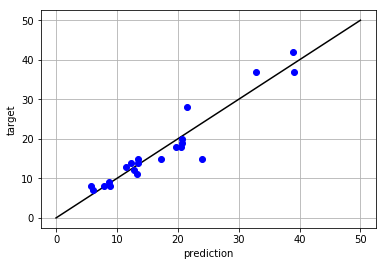

In [10]:
# visualize
plt.figure()
plt.xlabel('prediction')
plt.ylabel('target')
plt.grid(True)

# auxiliary line 
plt.plot([0, 50], [0, 50], 'k-')

plt.plot(huber_predicted, data.endog, 'o', color='blue')

# Compare to OLS

In [11]:
ols_model = sm.RLM(data.endog, data.exog, M=sm.robust.norms.LeastSquares()) # set M to be the criterion of OLS
ols_results = ols_model.fit()

print('--- Result ---')
print(ols_results.summary(yname='y', xname=['var_%d' % i for i in range(len(ols_results.params))]))

ols_predicted = ols_results.predict(data.exog)

--- Result ---
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                    LeastSquares                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 02 May 2019                                         
Time:                        01:46:20                                         
No. Iterations:                     2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var_0        -39.9197     11.896     

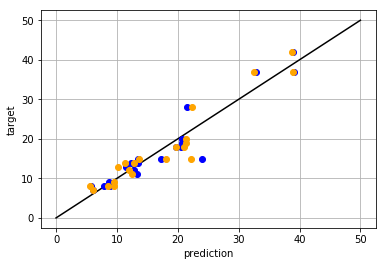

In [12]:
# visualize
plt.figure()
plt.xlabel('prediction')
plt.ylabel('target')
plt.grid(True)

# auxiliary line 
plt.plot([0, 50], [0, 50], 'k-')

plt.plot(huber_predicted, data.endog, 'o', color='blue')
plt.plot(ols_predicted, data.endog, 'o', color='orange')

In [13]:
# Mean Squared Error of Robust Linear Regression(Huber weight function)
huber_mse = st.eval_measures.mse(data.endog, huber_predicted)
print('MSE(Robust LR) : ', huber_mse)

# Mean Squared Error of OLS
ols_mse = st.eval_measures.mse(data.endog, ols_predicted)
print('MSE(OLS) : ', ols_mse)

# By only checking how training data fit to the model, OLS is more fittable than RLS. Estimation using test data should be done to see its effect.

MSE(Robust LR) :  9.073643089346657
MSE(OLS) :  8.515712457064692
